In [1]:
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT="MedQuery_LangGraph"

In [4]:
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["PINECONE_API_KEY"] = PINECONE_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "MedQuery_LangGraph"

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

c:\Users\Abhishek\Desktop\langgraph_learning\langgraph_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
llm.invoke("Hello!")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e8c0ef09-593a-44d6-89f2-459da26c22f3-0', usage_metadata={'input_tokens': 3, 'output_tokens': 9, 'total_tokens': 200, 'input_token_details': {'cache_read': 0}})

Let's make our state which will traverse to all Node

In [7]:
from typing import List
from typing_extensions import TypedDict

#Reason of creating this state is that we will let this value goes through all node and get updated.
class State(TypedDict):
    """
    Represents th state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    image_info: str
    Image_Valid: str
    documents: List[str]
    image_path: str

Creating a function to judge whether a given image is medical related or not

In [71]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
import base64
from PIL import Image as PILImage
import io

In [25]:
class GradeImage(BaseModel):
    """Binary score for relevance check on Image whether it is valid medical related Image or Not."""
    
    binary_score: str = Field(
        description="Image is relevant to medical aspects, 'yes' or 'no'"
    )

In [72]:
def preprocess_image(image_path: str, max_size: tuple = (512, 512)) -> PILImage:
    """Preprocess image for model input"""
    
    image = PILImage.open(image_path)
    
    image.thumbnail(max_size, PILImage.LANCZOS)
    
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    return image

In [73]:
def image_to_base64(image: PILImage) -> str:
    """Convert PIL Image to base64 encoded string"""
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG", quality=85)
    return base64.b64encode(buffered.getvalue()).decode()

In [74]:
def encode_image_to_base64(state):
    """Encode image to base64 string for Gemini model input"""
    print("Supported image formats: JPEG (.jpg, .jpeg), PNG (.png)")
    print("Recommended: Use JPEG format for best compatibility")
    image_path = state["image_path"] 
    
    # Preprocess the image
    processed_image = preprocess_image(image_path)  
    
    # Convert to base64
    base64_image = image_to_base64(processed_image)
    
    return base64_image

In [75]:
def create_image_grader(llm):
    """Create image grader for medical relevance"""
    structured_llm_grader = llm.with_structured_output(GradeImage)
    
    # System prompt
    system = """You are a grader assessing relevance of an input image to medical aspects. 
    Analyze the image content and determine if it contains medical-related elements such as:
    - Medical equipment, scans, anatomy, symptoms, conditions
    - Hospital/clinic environments, medical procedures
    - Medications or medical supplies
    
    Give a binary score 'yes' or 'no' to indicate whether the image is relevant to medical aspects."""
    
    # Create prompt with image format
    grade_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", [
            {
                "type": "text",
                "text": "Analyze this image for medical relevance:"
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": "data:image/jpeg;base64,{image_data}"
                }
            }
        ])
    ])
    
    return grade_prompt | structured_llm_grader

In [76]:
def grade_medical_image(state):
    """Grade whether an image is medical-related or not"""
    # Encode image to base64 with preprocessing
    base64_image = encode_image_to_base64(state)  # Pass state, not IMAGE_PATH
    
    # Create the grader chain
    retrieval_grader = create_image_grader(llm)
    
    Image_Valid = "Yes"

    # Invoke with image data
    score = retrieval_grader.invoke({"image_data": base64_image})
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: Image IS RELEVANT---")
    else:
        print("---GRADE: Image IS NOT RELEVANT---")
        Image_Valid = "No"
    return {"Image_Valid": Image_Valid}

In [77]:
state_instance = {
    "question": "",
    "generation": "",
    "image_info": "",
    "Image_Valid": "",
    "documents": [],
    "image_path": "C:/Users/Abhishek/Downloads/skin_image.jpg"  # Replace with actual image path
}

# Call the function with the instance
grade_medical_image(state_instance)

Supported image formats: JPEG (.jpg, .jpeg), PNG (.png)
Recommended: Use JPEG format for best compatibility
---GRADE: Image IS RELEVANT---


{'Image_Valid': 'Yes'}

In [90]:
def decide_to_generate(state):
    if state.get("Image_Valid") == "Yes":
        return "Get_Image_Info"
    else:
        return "reject"  # a custom node that handles rejection

In [41]:
def reject_question(state):
    print("---REJECTING: Not a medical image---")
    return {
        "question": state["question"],
        "documents": [],
        "generation": "Given Image Doesn't belong to Medical Domain"
    }

Let's get information regarding the image using Google Gemini model.

In [42]:
from langchain_core.output_parsers import StrOutputParser

In [48]:
def analyze_medical_image(state):
    """
    Analyze medical image and store detailed information in image_info string.
    
    Args:
        state: Current state of the workflow
        image_path: Path to the medical image
        llm: Language model with vision capabilities
    
    Returns:
        Updated state with image_info populated
    """
    
    # Medical analysis prompt
    medical_analysis_prompt = """You are an expert medical image analyst. Analyze this medical image and provide detailed information about:

1. Disease/Condition: What disease, condition, or medical finding is depicted?
2. Medical Terminology: List relevant medical terms and terminology
3. Anatomical Location: What body part or anatomical structure is affected?
4. Severity Assessment: Assess the severity or stage if determinable
5. Additional Findings: Any other medical observations

Provide a short analysis suitable for medical evaluation. Format your response in a optimal way."""

    # Create prompt template
    prompt = ChatPromptTemplate.from_messages([
        ("system", medical_analysis_prompt),
        ("human", [
            {
                "type": "text", 
                "text": "Please analyze this medical image and provide detailed medical information:"
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": "data:image/jpeg;base64,{image_data}"
                }
            }
        ])
    ])
    # Encode image to base64
    base64_image = encode_image_to_base64(state)
    
    # Create chain with StrOutputParser
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"image_data": base64_image})

    print("---Image Analysis---")
    print("response: ",response)

    # Store the analysis in image_info as string
    state["image_info"] = response
    
    return state

In [49]:
# Create a state dictionary instance
my_state = {
    "question": "",
    "generation": "",
    "image_info": "",
    "Image_Valid": "",
    "documents": [],
    "image_path": "C:/Users/Abhishek/Downloads/skin_image.jpg"
}

# Call with the dictionary instance
analyze_medical_image(my_state)

Supported image formats: JPEG (.jpg, .jpeg), PNG (.png)
Recommended: Use JPEG format for best compatibility
---Image Analysis---
response:  This image depicts common benign skin growths.

**1. Disease/Condition:**
*   **Skin tags (Acrochordons):** These are small, soft, benign skin growths that typically project from the surrounding skin on a narrow stalk (pedunculated).

**2. Medical Terminology:**
*   **Acrochordon:** The medical term for a skin tag.
*   **Fibroepithelial polyp:** Another medical term, reflecting their composition of fibrous tissue and epithelium.
*   **Benign neoplasm:** A non-cancerous growth.
*   **Pedunculated lesion:** Describes a lesion attached by a stalk.
*   **Papule/Nodule:** Small, raised skin lesions.

**3. Anatomical Location:**
*   **Neck:** Specifically, the lateral aspect of the neck and possibly extending to the supraclavicular or upper chest area.
*   **Skin:** The integumentary system.

**4. Severity Assessment:**
*   **Benign and Asymptomatic:** S

{'question': '',
 'generation': '',
 'image_info': 'This image depicts common benign skin growths.\n\n**1. Disease/Condition:**\n*   **Skin tags (Acrochordons):** These are small, soft, benign skin growths that typically project from the surrounding skin on a narrow stalk (pedunculated).\n\n**2. Medical Terminology:**\n*   **Acrochordon:** The medical term for a skin tag.\n*   **Fibroepithelial polyp:** Another medical term, reflecting their composition of fibrous tissue and epithelium.\n*   **Benign neoplasm:** A non-cancerous growth.\n*   **Pedunculated lesion:** Describes a lesion attached by a stalk.\n*   **Papule/Nodule:** Small, raised skin lesions.\n\n**3. Anatomical Location:**\n*   **Neck:** Specifically, the lateral aspect of the neck and possibly extending to the supraclavicular or upper chest area.\n*   **Skin:** The integumentary system.\n\n**4. Severity Assessment:**\n*   **Benign and Asymptomatic:** Skin tags are generally harmless and do not cause symptoms unless irrita

Now creating Better/Optimized Question for web-search

In [50]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate

system = """You a question re-writer that converts an input question and given image-info and getting key understanding of the image, converts an input question to a better version that is optimized \n 
     for web search. Give only 1 optimized question. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [51]:
question = "What happens if a person is having a pimple on his face n how to get rid of it?"
question_rewriter.invoke({"question": question})

'What causes facial acne and how can it be treated?'

In [52]:
def transform_question(state):
    """
    Transform the query to produce a better question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrase question
    """
    print("---TRANSFORMER QUERY---")

    question = state["question"] + state["image_info"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    # If the result is a dict, extract the actual question string
    if isinstance(better_question, dict):
        better_question = better_question.get("question", "")


    print("---NEW QUESTION---")
    print(better_question)
    
    return {"question": better_question}

In [53]:
transform_question(my_state)

---TRANSFORMER QUERY---
---NEW QUESTION---
What do benign skin tags (acrochordons) look like on the neck?


{'question': 'What do benign skin tags (acrochordons) look like on the neck?'}

For Web Search we will use Tavily

In [54]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=5)

In [55]:
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    
    web_results = "\n".join([d["content"] for d in docs])
    
    web_results = Document(page_content=web_results)
    
    documents.append(web_results)

    return {"documents": documents, "question": question}

Creating our RAG pipeline

In [56]:
from langchain.embeddings import HuggingFaceEmbeddings
#Loading the Embeddings from Hugging Face
def hugging_face_embeddings():
    embeddings=HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
    return embeddings

embeddings=hugging_face_embeddings()

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_25536\1330717160.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings=HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')


In [57]:
index_name = "medicalbot"

# Load Existing index 

from langchain_pinecone import PineconeVectorStore
# Embed each chunk and upsert the embeddings into your Pinecone index.
docsearch = PineconeVectorStore.from_existing_index(
    index_name=index_name,
    embedding=embeddings
)

In [58]:
docsearch

In [59]:
retriever = docsearch.as_retriever()

In [60]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

#Prompt
prompt = hub.pull("rlm/rag-prompt")
'''
Description:
This is a prompt for retrieval-augmented-generation. It is useful for chat, QA, or other applications that rely on passing context to an LLM.

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:

this the prompt associated with it,
'''
print(f"---PROMPT--- {prompt}")

# Post-Processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# RAG chain setup
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}  #RunnablePassthrough() is used to pass the question as it is to the LLM
    | prompt
    | llm
    | StrOutputParser()
)

---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [109]:
def generate(state):
    """
    Generate answer using RAG chain and web search

    Args:
        state (dict): The current graph state with 'question' and 'documents'
    
    Returns:
        state (dict): Updated state with 'generation' added
    """
    print("---GENERATE---")

    question = state["question"]
    documents = state["documents"]  # This contains web search results
    
    if documents is None or len(documents) == 0:
        if "generation" in state:
            return {
                "question": question,
                "documents": documents,
                "generation": state["generation"]  
            }
        else:
            return {
                "question": question,
                "documents": documents,
                "generation": "Error: No documents were retrieved before generation."
            }

    # Combine web search results with vector store retrieval
    vector_docs = retriever.invoke(question)  # Get from Pinecone
    
    # Combine both sources
    all_docs = documents + vector_docs  # Web search + Vector store
    
    # Format all documents
    context = format_docs(all_docs)
    print("---Generate---")
    # Create prompt manually since we're combining sources
    final_prompt = f"""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

    Question: {question}
    Context: {context}
    Answer:"""
    
    # Generate response
    generation = llm.invoke(final_prompt).content
    
    return {
        "documents": all_docs,
        "generation": generation,
        "question": question
    }

In [100]:
from langgraph.graph import END, StateGraph, START

In [110]:
workflow = StateGraph(State)

In [111]:
# Define the nodes
workflow.add_node("Get_Image_Info", analyze_medical_image) # retreive
workflow.add_node("grade_image", grade_medical_image) # grade_documents
workflow.add_node("generate", generate) # generate
workflow.add_node("transform_question", transform_question) # transformer_query
workflow.add_node("web_search_node", web_search) # web_search
workflow.add_node("reject", reject_question) # reject question which doesn't belong to medical domain

In [112]:
# Build graph
workflow.add_edge(START, "grade_image")

workflow.add_conditional_edges(
    "grade_image",
    decide_to_generate,
    {
        "Get_Image_Info": "Get_Image_Info",
        "reject": "reject"
    }
)
workflow.add_edge("reject", "generate")
workflow.add_edge("Get_Image_Info", "transform_question")

workflow.add_edge("transform_question", "web_search_node")

workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

In [113]:
# Compile
app = workflow.compile()

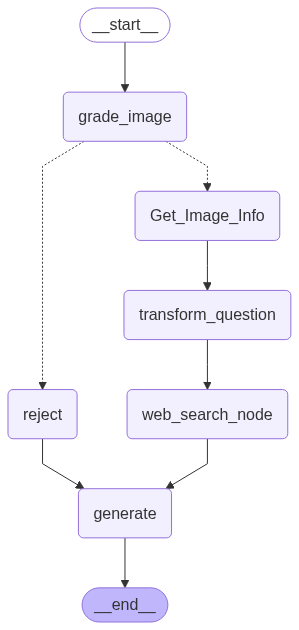

In [114]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [115]:
from pprint import pprint

In [116]:
inputs = {
    "question": "",
    "image_path": "C:/Users/Abhishek/Downloads/skin_image.jpg",  
    "documents": [],
    "generation": "",
    "image_info": "",
    "Image_Valid": ""
}

In [117]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

Supported image formats: JPEG (.jpg, .jpeg), PNG (.png)
Recommended: Use JPEG format for best compatibility
---GRADE: Image IS RELEVANT---
"Node 'grade_image':"
'\n---\n'
Supported image formats: JPEG (.jpg, .jpeg), PNG (.png)
Recommended: Use JPEG format for best compatibility
---Image Analysis---
response:  Here's an analysis of the medical image:

**1. Disease/Condition:**
The image depicts **skin tags**, medically known as **acrochordons** (or fibroepithelial polyps). These are common, benign (non-cancerous) growths of the skin.

**2. Medical Terminology:**
*   Acrochordon (plural: acrochordons)
*   Skin tag
*   Fibroepithelial polyp
*   Pedunculated lesion (referring to the stalk-like attachment)
*   Benign epidermal growth

**3. Anatomical Location:**
The lesions are located on the **neck**, specifically in the supraclavicular or lower cervical region. This is a common area for skin tags, along with other areas of skin folds (e.g., armpits, groin, eyelids).

**4. Severity Assessm

In [118]:
inputs = {
    "question": "How to get relief from it?",
    "image_path": "C:/Users/Abhishek/Downloads/skin_image.jpg",  
    "documents": [],
    "generation": "",
    "image_info": "",
    "Image_Valid": ""
}

In [119]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

Supported image formats: JPEG (.jpg, .jpeg), PNG (.png)
Recommended: Use JPEG format for best compatibility
---GRADE: Image IS RELEVANT---
"Node 'grade_image':"
'\n---\n'
Supported image formats: JPEG (.jpg, .jpeg), PNG (.png)
Recommended: Use JPEG format for best compatibility
---Image Analysis---
response:  This image displays common benign skin growths.

**1. Disease/Condition:**
*   **Acrochordons (Skin Tags):** These are common, benign, soft, skin-colored or hyperpigmented papules that often protrude from the skin on a narrow stalk.

**2. Medical Terminology:**
*   **Acrochordon:** The medical term for a skin tag.
*   **Skin Tag:** Common name for acrochordon.
*   **Benign:** Non-cancerous, harmless.
*   **Pedunculated:** Having a stalk-like base (as opposed to sessile, which is broad-based).
*   **Papule:** A small, raised, solid lesion on the skin.
*   **Epidermal proliferation:** An overgrowth of skin cells.

**3. Anatomical Location:**
*   **Neck/Supraclavicular Region:** The 